In [1]:
import os
import pickle
# import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
# from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
#from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
from torch.nn.parameter import Parameter


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class MLPBilPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
        super(MLPBilPredictor, self).__init__()
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
        for i in range(num_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i + 1]))
        self.bilin = torch.nn.Linear(hidden_channels[-1], hidden_channels[-1], bias=False)
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        self.relu = nn.GELU()

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.bilin.reset_parameters()

    def forward(self, x_i, x_j):
        for lin in self.lins:
            x_i, x_j = lin(x_i), lin(x_j)
            x_i, x_j = self.dropout(self.relu(x_i)), self.dropout(self.relu(x_j))
        x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
        # x = x1+x2
        # x = torch.sum(x_i * x_j, dim=-1)
        return x, x_i, x_j


# class MLPBilPredictor(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
#         super(MLPBilPredictor, self).__init__()
#         self.lins = torch.nn.ModuleList()
#         self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
#         for i in range(num_layers - 1):
#             self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i+1]))
#         # self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
#         # self.bilin = torch.nn.Linear(in_channels,in_channels, bias=False)
#         self.pre = torch.nn.Linear(hidden_channels[-1],1)
#         self.relu = nn.GELU()
#         self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
#
#     def reset_parameters(self):
#         for lin in self.lins:
#             lin.reset_parameters()
#         self.lin.reset_parameters()
#
#     def forward(self, x):
#         for lin in self.lins:
#             x= lin(x)
#             x= self.dropout(self.relu(x))
#         x = self.pre(x)
#         # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
#         # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
#         # x = x1+x2
#         # x = torch.sum(x_i * x_j, dim=-1)
#         return x

class HerGraph(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(HerGraph, self).__init__()
        self.pre = MLPBilPredictor(3584 + 128, [1024], 1, 0.3)
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        self.relu = nn.GELU()

    def decoderMLP(self, xm, xg):
#         xm = xm[edge[0]]
#         xg = xg[edge[1]]
        s, xm, xg = self.pre(xm, xg)
        return s, xm, xg

    def forward(self, xm1,xg1,xm2,xg2):
#         xm1 = seq_dict['miRNA']
#         xg1 = seq_dict['gene']
#         xm2 = x_dict['miRNA']
#         xg2 = x_dict['gene']
#         xm = self.dropout(self.relu(torch.cat([xm1, xm2], dim=1)))
#         xg = self.dropout(self.relu(torch.cat([xg1, xg2], dim=1)))
        xm = self.relu(torch.cat([xm1, xm2], dim=1))
        xg = self.relu(torch.cat([xg1, xg2], dim=1))
        s, xm, xg = self.decoderMLP(xm, xg)
        return s, xm, xg


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduce='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, classifications, targets):
        # classifcation:[N,K]
        # targets: [N,K]的one-hot编码
        alpha = self.alpha
        gamma = self.gamma
        # classifications = classifications.view(-1)  # 不经过sigmoid的classification；
        # targets = targets.view(-1)                  # 应该是 one-hot
        # ce_loss: 对应公式中 -log(pt),也就是普通的 交叉熵损失；--> 该函数接收未经sigmoid的函数；
        ce_loss = F.binary_cross_entropy_with_logits(classifications, targets, reduction="none")
        # focal loss
        p = torch.sigmoid(classifications)  # 经过sigmoid
        p_t = p * targets + (1 - p) * (1 - targets)  # 计算pt
        loss = ce_loss * ((1 - p_t) ** gamma)  # -log(pt) * (1-pt) ** ganmma
        if alpha >= 0:
            # 对应公式中alpha_t控制损失的权重
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets)  # 和pt求解过程一样
            loss = alpha_t * loss  # 最终focal loss
        if self.reduce == 'sum':
            loss = loss.sum()
        elif self.reduce == 'mean':
            loss = loss.mean()
        else:
            raise ValueError('reduce type is wrong!')
        return loss


class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1 - self.alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        #         loss = - self.alpha * pt ** self.gamma * target * torch.log(pt) - \
        #             (1-self.alpha)*(1 - pt)** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss


# def trainAll(model, train_data, lossF):
#     model.train()
#     out, _, _ = model(train_data.seq_dict, train_data.sim_dict, train_data.edge_index_dict,
#                       train_data['regulate'].edge_label_index)
#     out = out.view(-1)
#     # print('out')
#     rel = train_data['regulate'].edge_label
#     # loss = F.binary_cross_entropy_with_logits(out,rel)
#     loss = lossF(out, rel)
#     pre = torch.sigmoid(out)
#     assert torch.isnan(loss).sum() == 0, print(loss)
#     auc = roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
#     aupr = average_precision_score(rel.detach().numpy(), pre.detach().numpy())
#     #     out = model(train_data.x_dict,train_data.edge_index_dict)
#     #     pre=out[train_data['regulate'].edge_label_index[0],train_data['regulate'].edge_label_index[1]]
#     #     rel=train_data['regulate'].edge_label
#     #     loss = F.binary_cross_entropy_with_logits(pre,rel)
#     #     pre=torch.sigmoid(pre)
#     #     assert torch.isnan(loss).sum() == 0, print(loss)
#     #     auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     return (loss.item(), auc, aupr)


# def evaluateAll(model, dat, lossF):
#     model.eval()
#     valloss = 0
#     valauc = 0
#     with torch.no_grad():
#         out, _, _ = model(dat.seq_dict, dat.sim_dict, dat.edge_index_dict, dat['regulate'].edge_label_index)
#         out = out.view(-1)
#         rel = dat['regulate'].edge_label
#         # loss = F.binary_cross_entropy_with_logits(out,rel)
#         loss = lossF(out, rel)
#         pre = torch.sigmoid(out)
#         #         out = model(dat.x_dict,dat.edge_index_dict)
#         #         pre=out[dat['regulate'].edge_label_index[0],dat['regulate'].edge_label_index[1]]
#         #         rel=dat['regulate'].edge_label
#         #         loss = F.binary_cross_entropy_with_logits(pre,rel)
#         #         pre=torch.sigmoid(pre)
#         auc = roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
#         aupr = average_precision_score(rel.detach().numpy(), pre.detach().numpy())
#     return (loss.item(), auc, aupr)

def trainEpoch(model,trainloader,scaler,lossF,device):
    model.train()
    trainloss=0
    auc=0
    aupr=0
    #acc=0
    for step,dat in enumerate(trainloader):
        xm1,xg1,xm2,xg2,mid,gid,rel=dat
        xm1,xg1,xm2,xg2,mid,gid,rel=xm1.to(device),xg1.to(device),xm2.to(device),xg2.to(device),\
                                    mid.to(device),gid.to(device),rel.to(device)
        
        optimizer.zero_grad()
        # 训练模型
        #with autocast():
        #out = model(dat.x_dict,dat.seq_dict, dat.edge_index_dict)
        out,_,_ = model(xm1, xg1,xm2,xg2)
        out=out.view(-1)
        #pre=out[mid,gid]
        #print(rel)
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        loss=lossF(out,rel)
        #metric=model_evaluation(pre,rel.int())
        #print(out)
        pre=torch.sigmoid(out)
        #print(pre)
        #assert torch.isnan(loss).sum() == 0, print(loss)
        metric0=roc_auc_score(rel.cpu().detach().numpy(), pre.cpu().detach().numpy())
        metric1= average_precision_score(rel.cpu().detach().numpy(), pre.cpu().detach().numpy())
        #         scaler.scale(loss).backward()
        #         scaler.step(optimizer)  # optimizer.step
        #         scaler.update()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss = trainloss+loss.item()
        #acc=acc+metric['accuracy']
        auc=auc+metric0
        aupr=aupr+metric1
#         if (step % 100 == 0):
#             train_loss = (trainloss / (step+1))
#             auc_batch = (auc / (step+1))
#             aupr_batch = (aupr / (step+1))
#             #train_loss.append(trainloss)
#             print('Batch:',step,train_loss,auc_batch,aupr_batch)
    return (trainloss/(step+1),auc/(step+1),aupr/(step+1))

def evaluate(model,valloader,lossF,device):
    model.eval()
    valloss=0
    valauc=0
    valaupr=0
    with torch.no_grad():
        for step,dat in enumerate(valloader):
            xm1,xg1,xm2,xg2,mid,gid,rel=dat
            xm1,xg1,xm2,xg2,mid,gid,rel=xm1.to(device),xg1.to(device),xm2.to(device),xg2.to(device),\
                                        mid.to(device),gid.to(device),rel.to(device)

            optimizer.zero_grad()
            # 训练模型
            #with autocast():
            #out = model(dat.x_dict,dat.seq_dict, dat.edge_index_dict)
            out,_,_ = model(xm1, xg1,xm2,xg2)
            out=out.view(-1)
            #loss = F.binary_cross_entropy_with_logits(out,rel)
            loss=lossF(out,rel)
            #metric=model_evaluation(pre,rel.int())
            #print(rel,pre)
            pre=torch.sigmoid(out)
            auc=roc_auc_score(rel.cpu(), pre.cpu())
            aupr= average_precision_score(rel.cpu(), pre.cpu())
            valloss = valloss+loss.item()
            valauc=valauc+auc
            valaupr=valaupr+aupr
#             if (step % 100 == 0):
#                 val_loss = (valloss / (step+1))
#                 #val_loss.append(valloss)
#                 val_auc=(valauc/(step+1))
#                 val_aupr=(valaupr/(step+1))
#                 print('Batch:',step,val_loss,val_auc,val_aupr)
    return (valloss/(step+1)),(valauc/(step+1)),(valaupr/(step+1))


class EarlyStopping():
    def __init__(self, tolerance=50, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_best_auc, val_auc):
        if val_auc < val_best_auc:
            self.counter += 1
            if self.counter >= self.tolerance:
                self.early_stop = True


def transfer_model(pretrained_file, model):
    pretrained_dict = torch.load(pretrained_file, map_location=torch.device('cpu'))  # get pretrained dict
    model_dict = model.state_dict()  # get model dict
    pretrained_dict = transfer_state_dict(pretrained_dict, model_dict)
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model


def transfer_state_dict(pretrained_dict, model_dict):
    state_dict = {}
    for k, v in pretrained_dict.items():
        if k in model_dict.keys():
            state_dict[k] = v
        else:
            print("Missing key(s) in state_dict :{}".format(k))
    return state_dict

# class seqData(Dataset):
#     def __init__(self,xm,xg,label,edgeidx):
#         self.source= xm
#         self.target=xg
#         self.edge=edgeidx
#         self.label = label
#         self.length = len(self.label)
#     def __getitem__(self, index):
#         s=self.edge[0][index]
#         t=self.edge[1][index]
#         return self.source[s], self.target[t],s,t,self.label[index]
#     def __len__(self):
#         return self.length

class seqData(Dataset):
    def __init__(self,xm1,xg1,xm2,xg2,label,edgeidx):
        self.source1= xm1
        self.target1=xg1
        self.source2= xm2
        self.target2=xg2
        self.edge=edgeidx
        self.label = label
        self.length = len(self.label)
    def __getitem__(self, index):
        s=self.edge[0][index]
        t=self.edge[1][index]
        return self.source1[s], self.target1[t],self.source2[s], self.target2[t],s,t,self.label[index]
    def __len__(self):
        return self.length
    
# if __name__ == '__main__':

#     torch.cuda.set_device(0)
#     #os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments"
#     #PYTORCH_CUDA_ALLOC_CONF=expandable_segments
#     set_seed(2022)
#     with open('dataSplit_negall.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         _,_,_,_,trainidx,validx,testidx,trainId,trainLabel,testId,testLabel,valId,valLabel,_,m,g = pickle.load(f)
    
#     with open('./results/hnuResults/TranCNN_mgEmbedding.pkl',
#               'rb') as f:  # Python 3: open(..., 'rb')
#         xm1, xg1 = pickle.load(f)

#     with open('./results/hnuResults/HGTlinkloader_mgEmbedding.pkl',
#               'rb') as f:  # Python 3: open(..., 'rb')
#         xm2, xg2 = pickle.load(f)
    
#     train_data=seqData(xm1,xg1,xm2,xg2,trainLabel,trainId)
#     val_data=seqData(xm1,xg1,xm2,xg2,valLabel,valId)
#     #test_data=seqData(xm1,xm2,xg1,xg2,testLabel,testId)
    
#     train_loader = DataLoader(dataset=train_data, batch_size=1024*4, shuffle=True)
#     val_loader = DataLoader(dataset=val_data, batch_size=1024*4, shuffle=True)
#     #test_loader = DataLoader(dataset=test_data, batch_size=256, shuffle=True)
#     #del train_data,val_data
#     model = HerGraph(dropout_rate=0.3)
#     print(model)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     device='cuda:0'
#     model.to(device)

#     for m in model.modules():
#         if isinstance(m, (torch.nn.Linear, torch.nn.Conv1d, torch.nn.Conv2d)):
#             torch.nn.init.kaiming_normal_(m.weight, mode = 'fan_in')

#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-3)
#     scaler = torch.cuda.amp.GradScaler(enabled=True)
#     #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=0.000001)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',factor=0.5,verbose=1,min_lr=0.000001,patience=20)
#     #lossF=nn.BCEWithLogitsLoss()
#     #lossF=BCEFocalLoss(gamma=2, alpha=0.35, reduction='elementwise_mean')
#     lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')
#     early_stopping = EarlyStopping(tolerance=200, min_delta=0.15)

#     # Define the early stopping parameters
#     patience = 50
#     #best_va = float('inf')
#     counter = 0

#     import time
#     best_val_auc= best_val_aupr= 0
#     best_epoch=-1
#     trainloss=[]
#     valloss=[]
#     valauc=[]
#     trainauc=[]
#     valaupr=[]
#     trainaupr=[]
#     lrchange=[]
#     for epoch in range(1, 1001):
#         since = time.time()
#         print('{} optim: {}'.format(epoch, optimizer.param_groups[0]['lr']))
#         lrchange.append(optimizer.param_groups[0]['lr'])
#         train_loss, train_auc, train_aupr = trainEpoch(model,train_loader,scaler,lossF,device)
#         trainloss.append(train_loss)
#         print('train_loss:',train_loss)
#         #time_elapsed = time.time() - since
#         #print('Training in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         #since1 = time.time()
#         val_loss, val_auc, val_aupr = evaluate(model,val_loader,lossF,device)
#         valauc.append(val_auc)
#         valloss.append(val_loss)
#         trainauc.append(train_auc)
#         valaupr.append(val_aupr)
#         trainaupr.append(train_aupr)
#         #time_elapsed = time.time() - since1
#         #print('Val and Testing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         #scheduler.step()
#         scheduler.step(val_aupr)
#         if val_aupr > best_val_aupr:
#             best_val_auc = val_auc
#             best_val_aupr=val_aupr
#             counter = 0
#             best_epoch = epoch
#             #print(f'best aupr {epoch}')
#             torch.save(model, './miRGraph_stepbystep/Modelbest_gpu_pre_0.001.pt')
#             time_elapsed = time.time() - since
#             log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#             print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))
#         else:
#             counter += 1
#             time_elapsed = time.time() - since
#             log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#             print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))
#             if counter >= patience:
#                 print(f'Early stopping at epoch {epoch}')
#                 print(f'best aupr at epoch {best_epoch}')
#                 break
                
#         # if val_aupr > best_val_aupr:
#         #     best_val_auc = val_auc
#         #     best_val_aupr=val_aupr
#         #     torch.save(model, 'Modelbest.pt')
#         # #    test_auc= tmp_test_auc
#         # #scheduler.step()
#         # time_elapsed = time.time() - since
#         # log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#         # print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))

#         # early_stopping(train_auc, val_auc)
#         # if early_stopping.early_stop:
#         #     print("We are at epoch:", epoch)
#         #     break

#     with open('./miRGraph_stepbystep/ModelResult_gpu_pre_0.001.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#         pickle.dump([trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange], f)

#     torch.save(model, './miRGraph_stepbystep/Model_gpu_pre_0.001.pt')

In [2]:
torch.cuda.set_device(0)
set_seed(2022)

In [4]:
####### GPU############
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
model = torch.load("./results/hnuResults/miRGraph_stepbystep/Modelbest_gpu_pre_0.001.pt") ##hnu/24g
device='cuda:0'
model = model.to(device)
#HGT = HGT.to("cpu")
print(model)

with open('dataSplit_negall.pkl','rb') as f:  # Python 3: open(..., 'rb')
    _,_,_,_,trainidx,validx,testidx,trainId,trainLabel,testId,testLabel,valId,valLabel,_,m,g = pickle.load(f)

with open('./results/hnuResults/TranCNN_mgEmbedding.pkl',
          'rb') as f:  # Python 3: open(..., 'rb')
    xm1, xg1 = pickle.load(f)

with open('./results/hnuResults/HGTlinkloader_mgEmbedding.pkl',
          'rb') as f:  # Python 3: open(..., 'rb')
    xm2, xg2 = pickle.load(f)


test_data=seqData(xm1,xg1,xm2,xg2,testLabel,testId)
test_loader = DataLoader(dataset=test_data, batch_size=1024*2, shuffle=True)


model.eval()
valloss=0
valauc=0
valaupr=0
allpre=[]
allrel=[]
allmid=[]
allgid=[]
with torch.no_grad():
    for step,dat in enumerate(test_loader):
        xm1,xg1,xm2,xg2,mid,gid,rel=dat
        xm1,xg1,xm2,xg2,mid,gid,rel=xm1.to(device),xg1.to(device),xm2.to(device),xg2.to(device),\
                                    mid.to(device),gid.to(device),rel.to(device)
        # 训练模型
        #with autocast():
        #out = model(dat.x_dict,dat.seq_dict, dat.edge_index_dict)
        out,_,_ = model(xm1, xg1,xm2,xg2)
        out=out.view(-1)
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        #loss=lossF(out,rel)
        #metric=model_evaluation(pre,rel.int())
        #print(rel,pre)
        pre=torch.sigmoid(out)
        allpre.append(pre)
        allrel.append(rel)
        allmid.append(mid)
        allgid.append(gid)
        auc=roc_auc_score(rel.cpu(), pre.cpu())
        aupr= average_precision_score(rel.cpu(), pre.cpu())
        
        #valloss = valloss+loss.item()
        valauc=valauc+auc
        valaupr=valaupr+aupr
        if (step % 100 == 0):
            #val_loss = (valloss / (step+1))
            #val_loss.append(valloss)
            val_auc=(valauc/(step+1))
            val_aupr=(valaupr/(step+1))
            print('Batch:',step,val_auc,val_aupr)
  

HerGraph(
  (pre): MLPBilPredictor(
    (lins): ModuleList(
      (0): Linear(in_features=3712, out_features=1024, bias=True)
    )
    (bilin): Linear(in_features=1024, out_features=1024, bias=False)
    (dropout): Dropout(p=0.3, inplace=False)
    (relu): GELU(approximate='none')
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): GELU(approximate='none')
)
Batch: 0 0.9588619291350674 0.939123409552469


In [5]:
print(valaupr/(step+1),valauc/(step+1)) ## 0.9322905673580077 0.9563357716107425 #0.9318854786034283 0.9561838693744412

0.9318854786034283 0.9561838693744412


In [6]:
pre=allpre[0]
rel=allrel[0]
mid=allmid[0]
gid=allgid[0]
for i in range(1,len(allpre)):
    pre=torch.cat([pre,allpre[i]])
    rel=torch.cat([rel,allrel[i]])
    mid=torch.cat([mid,allmid[i]])
    gid=torch.cat([gid,allgid[i]])

pre=pre.cpu()
rel=rel.cpu()
mid=mid.cpu()
gid=gid.cpu()

allrelpos=torch.nonzero(rel==1).squeeze()
print(allrelpos.size())
allrelneg=torch.nonzero(rel==0).squeeze()
print(allrelneg.size())

allprepos=torch.nonzero(pre>=0.5).squeeze()##从0开始
print(allprepos.size())
allpreneg=torch.nonzero(pre<0.5).squeeze()##从0开始
print(allpreneg.size())

a=set(allprepos.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1569

a=set(allprepos.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
fp=c
print(fp.size())#793

a=set(allpreneg.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
tn=c
print(tn.size())#5197

a=set(allpreneg.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
fn=c
print(fn.size())#654

recall=tp.size(0)/(tp.size(0)+fn.size(0))
print(recall)

precision=tp.size(0)/(tp.size(0)+fp.size(0))
print(precision)

f1 = 2 * precision * recall / (precision + recall)
print(f1)

# with open('./results/TransCNN_resultgpu.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([tp,fp,tn,fn,rel,pre], f)

with open('./results/hnuResults/results/miRGraphstepbystep_resultgpu.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([tp,fp,tn,fn,rel,pre], f)

torch.Size([32337])
torch.Size([66694])
torch.Size([32379])
torch.Size([66652])
torch.Size([27747])
torch.Size([4632])
torch.Size([62062])
torch.Size([4590])
0.8580573337044253
0.8569443157602149
0.8575004635638791


In [14]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def get_confusion_matrix(trues, preds):
    labels = [0,1]
    conf_matrix = confusion_matrix(trues, preds)
    return conf_matrix

def get_acc_p_r_f1(trues, preds):
    labels = [1]
    TP,FP,FN,TN = 0,0,0,0
    for label in labels:
        preds_tmp = np.array([1 if pred == label else 0 for pred in preds])
        trues_tmp = np.array([1 if true == label else 0 for true in trues])
        # print(preds_tmp, trues_tmp)
        # print()
        # TP预测为1真实为1
        # TN预测为0真实为0
        # FN预测为0真实为1
        # FP预测为1真实为0
        TP += ((preds_tmp == 1) & (trues_tmp == 1)).sum()
        TN += ((preds_tmp == 0) & (trues_tmp == 0)).sum()
        FN += ((preds_tmp == 0) & (trues_tmp == 1)).sum()
        FP += ((preds_tmp == 1) & (trues_tmp == 0)).sum()
    print(TP, FP, FN,TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def get_p_r_f1_from_conf_matrix(conf_matrix):
    TP,FP,FN,TN = 0,0,0,0
    labels = [1]
    nums = len(labels)
    for i in labels:
        TP += conf_matrix[i, i]
        FP += (conf_matrix[:i, i].sum() + conf_matrix[i+1:, i].sum())
        FN += (conf_matrix[i, i+1:].sum() + conf_matrix[i, :i].sum())
    print(TP, FP, FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

t=rel
s=pre
t1=t.cpu().numpy()
print(len(t1))
print(len(t1[t1==1]))
s1=s.cpu().numpy()
s1[s1>0.5]=1
s1[s1<=0.5]=0
print(len(s1[s1==1]),len(s1[s1==0]))
mat=get_confusion_matrix(t1, s1)
precision, recall, f1=get_p_r_f1_from_conf_matrix(mat)
print(precision, recall, f1)
precision, recall, f1=get_acc_p_r_f1(t.cpu().numpy(), s1)
print(precision, recall, f1)

99031
32337
32379 66652
27747 4632 4590
0.8569443157602149 0.8580573337044253 0.8575004635638791
27747 4632 4590 62062
0.8569443157602149 0.8580573337044253 0.8575004635638791


In [15]:
import os
import pickle
import torch
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
with open('./results/hnuResults/results/miRGraph_stepbystep_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
        _,_,_,_,t,s = pickle.load(f)
# with open('./results/TransCNN_resultgpu.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         _,_,_,_,t,s = pickle.load(f)
fpr, tpr, thresholds = roc_curve(t.cpu().numpy(), s.cpu().numpy(), pos_label=1)
testauc=auc(fpr,tpr)#0.8198
print(testauc)
precision, recall, th = precision_recall_curve(t.cpu().numpy(), s.cpu().numpy(),pos_label=1)
testaupr= average_precision_score(t.cpu().numpy(),s.cpu().numpy(),pos_label=1)
print(testaupr) #0.8026

0.9561624112071189
0.9319663111116976


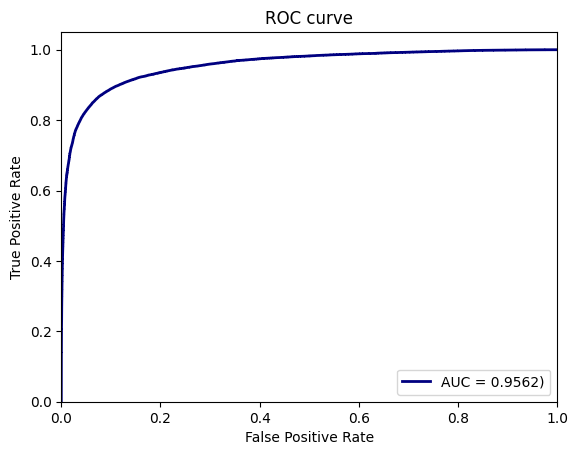

In [14]:
plt.figure()
plt.step(fpr, tpr,color='navy',linewidth=2,label='AUC = {0:.4f})'.format(testauc))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.savefig("auc_curve.jpg")

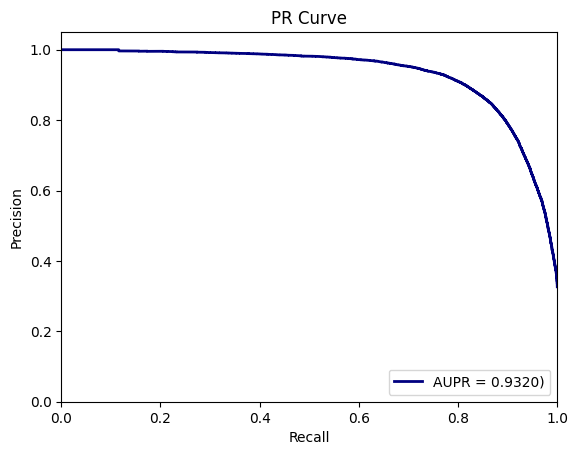

In [15]:
plt.figure()
plt.step(recall,precision,color='navy',linewidth=2,label='AUPR = {0:.4f})'.format(testaupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR Curve')
plt.legend(loc=4)
plt.savefig("pr_curve.jpg")

In [16]:
#/home/liupei89/shfolder/new/TransCNN/3/data10_0.35_0.0001_500
#/home/liupei89/shfolder/new/TransCNN/4/data10_0.25_500
#/home/liupei89/shfolder/new/TransCNN/1
with open('./results/hnuResults/miRGraph_stepbystep/ModelResult_gpu_pre_0.001.pkl','rb') as f:  # Python 3: open(..., 'rb')
        trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

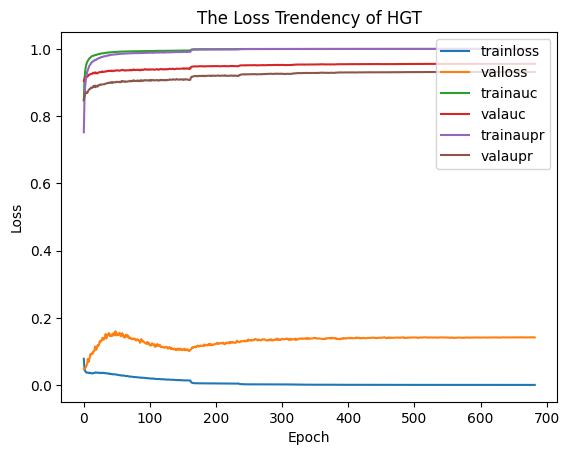

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trainloss,label='trainloss')
plt.plot(valloss,label='valloss')
plt.plot(trainauc,label='trainauc')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HGT')
plt.legend(loc=1)

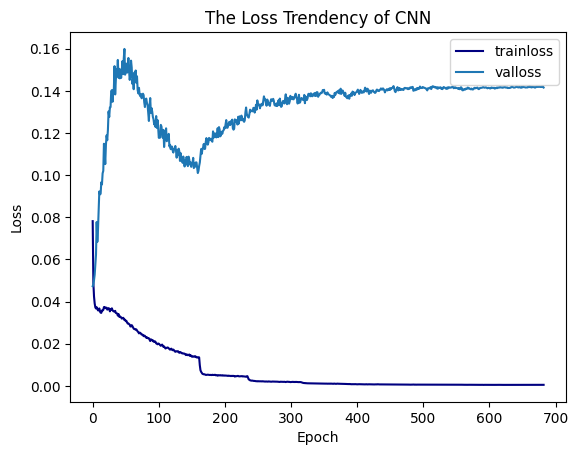

In [18]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss',color='navy')
plt.plot(valloss,label='valloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.xlim([0.0, 300])
plt.title('The Loss Trendency of CNN')
plt.legend(loc=1)

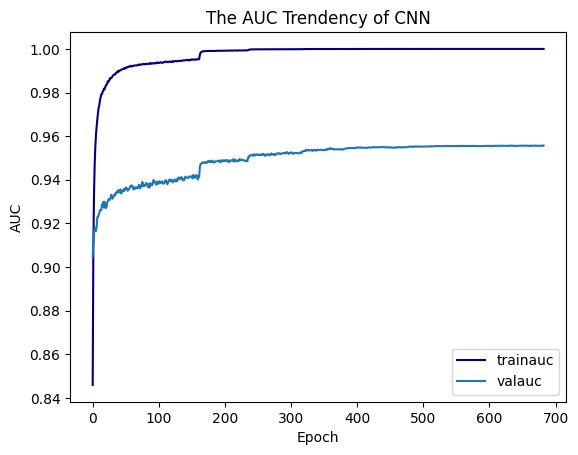

In [19]:
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
#plt.ylim([0.7, 0.9])
#plt.xlim([0.0, 1.0])
plt.title('The AUC Trendency of CNN')
plt.legend(loc=4)

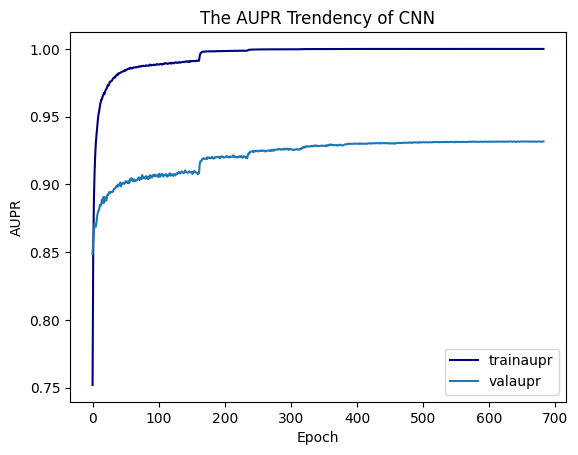

In [20]:
plt.figure()
plt.plot(trainaupr,label='trainaupr',color='navy')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
plt.title('The AUPR Trendency of CNN')
plt.legend(loc=4)

In [17]:
####### Obtain final miRNA and Gene embedding ############
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
model = torch.load("./results/hnuResults/miRGraph_stepbystep/Modelbest_gpu_pre_0.001.pt") ##hnu/24g
device='cpu'
model = model.to(device)
#HGT = HGT.to("cpu")
print(model)

with open('dataCombine_negall.pkl','rb') as f:  # Python 3: open(..., 'rb')
    train_data,val_data,test_data,m,g = pickle.load(f)

train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
nodetypes=train_data.node_types
metadata=train_data.metadata()

tmp=torch.cat([train_data ['regulate'].edge_label_index,val_data ['regulate'].edge_label_index],dim=1)
tmp=torch.cat([tmp,test_data ['regulate'].edge_label_index],dim=1)
label=torch.cat([train_data ['regulate'].edge_label,val_data ['regulate'].edge_label],dim=0)
label=torch.cat([label,test_data ['regulate'].edge_label],dim=0)
train_data['regulate'].edge_index=tmp
train_data['regulate'].edge_label_index=tmp
train_data['regulate'].edge_label=label

with open('./results/hnuResults/TranCNN_mgEmbedding.pkl',
          'rb') as f:  # Python 3: open(..., 'rb')
    xm1, xg1 = pickle.load(f)

with open('./results/hnuResults/HGTlinkloader_mgEmbedding.pkl',
          'rb') as f:  # Python 3: open(..., 'rb')
    xm2, xg2 = pickle.load(f)


test_data=seqData(xm1,xg1,xm2,xg2,train_data['regulate'].edge_label,train_data['regulate'].edge_label_index)
test_loader = DataLoader(dataset=test_data, batch_size=test_data.length, shuffle=True)


model.eval()
valloss=0
valauc=0
valaupr=0
allpre=[]
allrel=[]
allmid=[]
allgid=[]
with torch.no_grad():
    for step,dat in enumerate(test_loader):
        xm1,xg1,xm2,xg2,mid,gid,rel=dat
        xm1,xg1,xm2,xg2,mid,gid,rel=xm1.to(device),xg1.to(device),xm2.to(device),xg2.to(device),\
                                    mid.to(device),gid.to(device),rel.to(device)
        # 训练模型
        #with autocast():
        #out = model(dat.x_dict,dat.seq_dict, dat.edge_index_dict)
        out,_,_,mf,gf = model(xm1, xg1,xm2,xg2)
        out=out.view(-1)
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        #loss=lossF(out,rel)
        #metric=model_evaluation(pre,rel.int())
        #print(rel,pre)
        pre=torch.sigmoid(out)
        allpre.append(pre)
        allrel.append(rel)
        allmid.append(mid)
        allgid.append(gid)
        auc=roc_auc_score(rel.cpu(), pre.cpu())
        aupr= average_precision_score(rel.cpu(), pre.cpu())
        
        #valloss = valloss+loss.item()
        valauc=valauc+auc
        valaupr=valaupr+aupr
        print(step,auc,aupr)

print(aupr,auc) 
with open('./results/miRGraphStepbystep_mgEmbedding_allKnown.pkl', 'wb') as f:  # Python 3: open(..., 'wb') ### 不对
    pickle.dump([mf,gf], f)

HerGraph(
  (pre): MLPBilPredictor(
    (lins): ModuleList(
      (0): Linear(in_features=3712, out_features=1024, bias=True)
    )
    (bilin): Linear(in_features=1024, out_features=1024, bias=False)
    (dropout): Dropout(p=0.3, inplace=False)
    (relu): GELU(approximate='none')
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): GELU(approximate='none')
)
0 0.9957905768672451 0.9934225351624192
0.9934225351624192 0.9957905768672451


In [18]:
print(mf.size(),gf.size())

torch.Size([990302, 1024]) torch.Size([990302, 1024])
